# Homework Assignment

Using logistic regression, determine which IPO stocks to trade.

## Steps
- Feature Engineering: clean the underlying data set (eliminate and "fix" any null values, convert objects to numeric values (where appropriate... via mapping categorical features and simply converting to floats and ints).  then, add features (and then eliminate the underlying features, where appropriate).  additional features will include adding SPY performance to the dataset.  Normally, I would look to identify and eliminate features that won't contribute to the model (not too many since the original dataset doesn't have a ton of columns).
- Split the data into in/out of sample:  since this is time series data, we can use the earlier data to train and then test on the more recent data.
- Feature Scaling: normalize the data using StandardScaler
- Using a GridSearch with Pipeline and Cross Validation, model the data using both Logistc Regression and KNeighborsClassifier.

In [1212]:
import pandas as pd
import numpy as np

In [1213]:
# from iposcoop.com... but needs some cleaning
IPO = pd.read_csv('ipo_scoop.csv', usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
                 skiprows=2, names=['date', 'issuer', 'symbol', 'managers', 'offer_price', 'open_price', 'first_day_close', 
                                    'first_day_pctchg', 'dollar_change_open', 'dollar_change_close', 'star_rating', 'performed'])

In [1214]:
IPO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 12 columns):
date                   3123 non-null object
issuer                 3123 non-null object
symbol                 3123 non-null object
managers               3123 non-null object
offer_price            3123 non-null object
open_price             3123 non-null object
first_day_close        3123 non-null object
first_day_pctchg       3123 non-null object
dollar_change_open     3123 non-null object
dollar_change_close    3123 non-null object
star_rating            3123 non-null object
performed              357 non-null object
dtypes: object(12)
memory usage: 292.9+ KB


In [1215]:
IPO.head()

,date,issuer,symbol,managers,offer_price,open_price,first_day_close,first_day_pctchg,dollar_change_open,dollar_change_close,star_rating,performed
0,2/16/18,Farmmi,FAMI,ViewTrade Securities,$4.00,$4.40,$6.18,54.50%,$0.40,$2.18,N/C,NaN
1,3/16/18,Senmiao Technology,AIHS,ViewTrade Securities,$4.00,$5.51,$5.56,39.00%,$1.51,$1.56,1,Missed
2,3/20/18,Golden Bull,DNJR,ViewTrade Securities,$4.00,$5.20,$4.62,15.50%,$1.20,$0.62,N/C,NaN
3,2/14/18,Motus GI Holdings,MOTS,Piper Jaffray/ Oppenheimer,$5.00,$5.00,$4.38,-12.40%,$0.00,-$0.62,1,NaN
4,2/1/18,One Stop Systems,OSS,Roth Capital Partners,$5.00,$5.55,$4.88,-2.40%,$0.55,-$0.12,1,NaN


In [1216]:
# get rid of $ signs (leading) on numbers... % signs (trailing)
IPO = IPO.applymap(lambda x: x if not '$' in str(x) else x.replace('$', ''))
IPO = IPO.applymap(lambda x: x if not '%' in str(x) else x.replace('%', ''))

In [1217]:
# attempt to convert date from object to datetime using statement: df.date = pd.to_datetime(df.date)
# this fails because of a single row that has an error.  identify and fix the row.
IPO[IPO['date'] == '11/120']  
IPO.loc[1258, 'date'] = '2012-11-20'
IPO['date'] = pd.to_datetime(IPO['date'])
IPO=IPO.sort_values('date')

In [1218]:
IPO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3123 entries, 2886 to 57
Data columns (total 12 columns):
date                   3123 non-null datetime64[ns]
issuer                 3123 non-null object
symbol                 3123 non-null object
managers               3123 non-null object
offer_price            3123 non-null object
open_price             3123 non-null object
first_day_close        3123 non-null object
first_day_pctchg       3123 non-null object
dollar_change_open     3123 non-null object
dollar_change_close    3123 non-null object
star_rating            3123 non-null object
performed              357 non-null object
dtypes: datetime64[ns](1), object(11)
memory usage: 317.2+ KB


In [1219]:
IPO.columns

Index(['date', 'issuer', 'symbol', 'managers', 'offer_price', 'open_price',
       'first_day_close', 'first_day_pctchg', 'dollar_change_open',
       'dollar_change_close', 'star_rating', 'performed'],
      dtype='object')

In [1220]:
# from describe, we see that star_ratings has no missing records and six distinct values
# see what those values are, with the hope of ultimately converting to a ordinal value
# after reviewing, the ratings are from 1-5... with some N/C values which I'm classifying as 0
#IPO.describe()
#IPO["star_rating"].value_counts()
IPO.star_rating.replace('N/C', 0, inplace=True)

In [1221]:
# convert all possible columns to numeric
# similar to going through one-by-one and running: df['offer_price'] = df['offer_price'].astype('float')
for col in IPO.columns[4:11]:
    IPO[col] = IPO[col].astype('float')

In [1222]:
# IPO[IPO["managers"].str.contains('/', regex=False)].info()
IPO.managers=IPO.managers.str.split('/').apply(lambda x: x[0])

IPO['count'] = IPO.groupby('managers')['managers'].transform('count')
IPO['managers'] = np.where(IPO['count'] < 10, 'other', IPO['managers'])
IPO.drop(columns=['count'], inplace=True)

managers_dummies = pd.get_dummies(IPO.managers, drop_first=True, prefix='mgrs')
IPO=IPO.join(managers_dummies)

In [1223]:
IPO.head()

,date,issuer,symbol,managers,offer_price,open_price,first_day_close,first_day_pctchg,dollar_change_open,dollar_change_close,...,mgrs_SG Cowen,mgrs_Salomon Smith Barney,mgrs_Stifel,mgrs_Thomas Weisel Partners,mgrs_UBS Investment Bank,mgrs_UBS Warburg,mgrs_Wachovia,mgrs_Wells Fargo Securities,mgrs_William Blair,mgrs_other
2886,2000-05-12,Sequoia Software,SQSW,Lehman Brothers,8.0,10.25,10.06,25.78,2.25,2.06,...,0,0,0,0,0,0,0,0,0,0
2887,2000-05-18,US Unwired,UNWR,other,11.0,11.03,11.06,0.57,0.03,0.06,...,0,0,0,0,0,0,0,0,0,1
2888,2000-05-18,Nogatech,NGTC,other,12.0,11.88,9.41,-21.61,-0.13,-2.59,...,0,0,0,0,0,0,0,0,0,1
2890,2000-05-18,New Focus,NUFO,Credit Suisse First Boston,20.0,40.00,51.00,155.00,20.00,31.00,...,0,0,0,0,0,0,0,0,0,0
2889,2000-05-18,iBEAM Broadcasting,IBEM,Morgan Stanley Dean Witter,10.0,11.50,14.00,40.00,1.50,4.00,...,0,0,0,0,0,0,0,0,0,0


In [1224]:
IPO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3123 entries, 2886 to 57
Data columns (total 64 columns):
date                               3123 non-null datetime64[ns]
issuer                             3123 non-null object
symbol                             3123 non-null object
managers                           3123 non-null object
offer_price                        3123 non-null float64
open_price                         3123 non-null float64
first_day_close                    3123 non-null float64
first_day_pctchg                   3123 non-null float64
dollar_change_open                 3123 non-null float64
dollar_change_close                3123 non-null float64
star_rating                        3123 non-null float64
performed                          357 non-null object
mgrs_Baird                         3123 non-null uint8
mgrs_Banc of America               3123 non-null uint8
mgrs_Barclays                      3123 non-null uint8
mgrs_Barclays Capital              3123 n

In [1225]:
# add predictor variable - return from open to close.
# set the target variable to 1 or 0
# add a variable for Gap return 
IPO["IPO_Day1_Return"]=(IPO["first_day_close"]-IPO["open_price"])/IPO["open_price"]
IPO["IPO_Gap"]=(IPO["open_price"]-IPO["offer_price"])/IPO["offer_price"]
IPO["target"]=IPO["IPO_Day1_Return"].apply(lambda x:(x>0)*1)

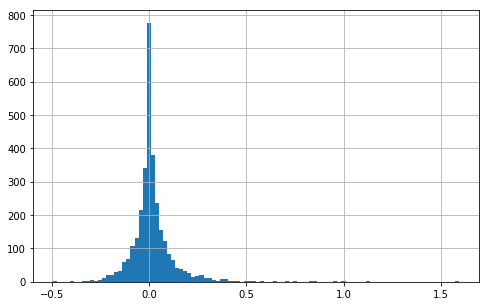

In [1226]:
IPO["IPO_Day1_Return"].hist(bins = 100, figsize = (8, 5))

In [1227]:
# get rid of non-numeric and irrelevent columns
IPO.drop(columns=["performed","dollar_change_open","dollar_change_close","symbol","issuer",
                  "managers","first_day_pctchg","offer_price","open_price","first_day_close"],axis=1,inplace=True)

In [1228]:
# add spy data and features related to the spy
SPY = pd.read_csv('spy_updated.csv')

SPY['Date'] = pd.to_datetime(SPY['Date'])

#SPY.head()

SPY["PrevDate"]=SPY["Date"].shift(1)
SPY["POL"]=(SPY["Close"]-SPY["Low"])/(SPY["High"]-SPY["Low"])
SPY["PrevClo"]=SPY["Adj Close"].shift(1)
SPY["Ret"]=(SPY["Adj Close"]-SPY["PrevClo"])/SPY["PrevClo"]
SPY["GapRet"]=(SPY["Open"]-SPY["PrevClo"])/SPY["PrevClo"]
SPY_Prev=SPY[["PrevDate","POL","Ret"]]
SPY_Prev=SPY_Prev.rename(columns={'PrevDate': 'date'})

SPY.rename(columns={'Date': 'date'},inplace=True)
SPY=SPY[["date","GapRet"]].merge(SPY_Prev,how='left',left_on=['date'],right_on=['date'])
SPY.rename(columns={'GapRet': 'GapRet_SPY','POL': 'prevPOL_SPY','Ret': 'prevRet_SPY'}, inplace=True)

In [1229]:
IPO=IPO.merge(SPY,how='left',left_on=['date'],right_on=['date'])

In [1230]:
IPO.GapRet_SPY.fillna(IPO['GapRet_SPY'].mean(skipna=True),inplace=True)
IPO.prevPOL_SPY.fillna(IPO['prevPOL_SPY'].mean(skipna=True),inplace=True)
IPO.prevRet_SPY.fillna(IPO['prevRet_SPY'].mean(skipna=True),inplace=True)

In [1231]:
IPO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3123 entries, 0 to 3122
Data columns (total 60 columns):
date                               3123 non-null datetime64[ns]
star_rating                        3123 non-null float64
mgrs_Baird                         3123 non-null uint8
mgrs_Banc of America               3123 non-null uint8
mgrs_Barclays                      3123 non-null uint8
mgrs_Barclays Capital              3123 non-null uint8
mgrs_Bear Stearns                  3123 non-null uint8
mgrs_BofA Merrill Lynch            3123 non-null uint8
mgrs_CIBC World Markets            3123 non-null uint8
mgrs_CS First Boston               3123 non-null uint8
mgrs_Chase H&Q                     3123 non-null uint8
mgrs_Citi                          3123 non-null uint8
mgrs_Citigroup                     3123 non-null uint8
mgrs_Cowen                         3123 non-null uint8
mgrs_Cowen and Company             3123 non-null uint8
mgrs_Credit Suisse                 3123 non-null uint8
mg

In [1232]:
# write a split function that takes in sorted data and splits 75/25 or whatever
def train_test_split_over_time(df_x,df_y,splitPct=0.75):
    record_count=df_x.shape[0]
    train_count=int(np.rint(0.75*record_count))
    df_x_train=df_x[:train_count]
    df_y_train=df_y[:train_count]
    df_x_test=df_x[train_count:]
    df_y_test=df_y[train_count:]
    return df_x_train, df_x_test, df_y_train, df_y_test

In [1233]:
from sklearn.model_selection import train_test_split

In [1234]:
## train test split over time
y=IPO['target']
X=IPO.drop(['date','IPO_Day1_Return','target'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split_over_time(X, y)
#X_train, X_test, y_train, y_test = train_test_split(X,y)

In [1235]:
from sklearn.linear_model import LogisticRegression

In [1236]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [1237]:
params = {'lasso__alpha':[20,25],'polynomialfeatures__degree':[1]}

pipe=make_pipeline(StandardScaler(),PolynomialFeatures(), Lasso())
grid = GridSearchCV(pipe,param_grid=params, cv=3)   # create a grid object to put the pipeline into
grid.fit(X_train,y_train)
best=grid.best_estimator_
score=best.score(X_test,y_test)
prediction=best.predict(X_test)
rmse=np.sqrt(mean_squared_error(prediction,y_test))
best_params=str(grid.best_params_)
print("rmse=",rmse," (score={:.3f}".format(score),"); ",best_params)
# grid.best_estimator_.named_steps.lasso  is the same as "lasso." if there were no grid
print("number of coefficients ",np.sum(grid.best_estimator_.named_steps.lasso.coef_ != 0),
      " out of:", len(X_train.columns))

rmse= 0.5001115184027989  (score=-0.008 );  {'lasso__alpha': 20, 'polynomialfeatures__degree': 1}
number of coefficients  0  out of: 57


In [1238]:
def run_model(model,params):
    pipe=make_pipeline(StandardScaler(),PolynomialFeatures(), model)
    grid = GridSearchCV(pipe,param_grid=params, scoring = 'roc_auc', cv=5)   # create a grid object to put the pipeline into
    grid.fit(X_train,y_train)
    best=grid.best_estimator_
    score=best.score(X_test,y_test)
    best_params=str(grid.best_params_)
    print(" (score={:.3f}".format(score),"); ",best_params,"\n")
    print("classification report:\n",classification_report(y_test,best.predict(X_test)))
    print("confusion matrix:\n",confusion_matrix(y_test,best.predict(X_test)))

### Results below are the best I could find

In [1239]:
# pass a linear regression model and parameters.  data will be scaled
params = {'polynomialfeatures__degree':[1,2],'logisticregression__C': [0.02,0.025,0.03,0.035]}
run_model(LogisticRegression(penalty='l1'),params)

 (score=0.539 );  {'logisticregression__C': 0.025, 'polynomialfeatures__degree': 1} 

classification report:
              precision    recall  f1-score   support

          0       0.55      0.79      0.65       424
          1       0.49      0.24      0.32       357

avg / total       0.52      0.54      0.50       781

confusion matrix:
 [[335  89]
 [271  86]]


### Results above are the best I could find

In [1240]:
# commented out below has worse results
#params = {'polynomialfeatures__degree':[1,2],'logisticregression__C': [0.01,0.02,0.03,0.04,0.05]}
#run_model(LogisticRegression(),params)

In [1241]:
from sklearn.dummy import DummyClassifier

In [1242]:
dumm = DummyClassifier()
dumm.fit(X_train,y_train)
DummyClassifier(constant=None, random_state=None, strategy='stratified')

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [1243]:
dumm.score(X_test,y_test)

0.4942381562099872

In [1244]:
print(classification_report(y_test,dumm.predict(X_test)))

             precision    recall  f1-score   support

          0       0.53      0.50      0.51       424
          1       0.44      0.47      0.45       357

avg / total       0.49      0.48      0.48       781



In [1245]:
from sklearn.neighbors import KNeighborsClassifier

In [1246]:
# pass a linear regression model and parameters.  data will be scaled
params = {'polynomialfeatures__degree':[1],'kneighborsclassifier__n_neighbors': [1,2,3,4,5]}
run_model(KNeighborsClassifier(),params)

 (score=0.515 );  {'kneighborsclassifier__n_neighbors': 5, 'polynomialfeatures__degree': 1} 

classification report:
              precision    recall  f1-score   support

          0       0.55      0.59      0.57       424
          1       0.47      0.42      0.44       357

avg / total       0.51      0.51      0.51       781

confusion matrix:
 [[252 172]
 [207 150]]
